Step 1: Import Libraries and Load Dataset

# Before running this code, please install the CSV file from [Kaggle](https://www.kaggle.com/datasets/samxsam/human-cognitive-performance-analysis), or from the CSV file attached to Project Milestone 5

In [36]:
#Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler


from sklearn.metrics import mean_squared_error, r2_score
# Load the dataset and make sure its loaded correctly
from google.colab import files
files.upload()
df = pd.read_csv('human_cognitive_performance.csv')
df.head()

Saving human_cognitive_performance.csv to human_cognitive_performance (1).csv


,User_ID,Age,Gender,Sleep_Duration,Stress_Level,Diet_Type,Daily_Screen_Time,Exercise_Frequency,Caffeine_Intake,Reaction_Time,Memory_Test_Score,Cognitive_Score,AI_Predicted_Score
0,U1,57,Female,6.5,3,Non-Vegetarian,6.5,Medium,41,583.33,65,36.71,39.77
1,U2,39,Female,7.6,9,Non-Vegetarian,10.8,High,214,368.24,58,54.35,57.68
2,U3,26,Male,8.2,6,Vegetarian,5.7,Low,429,445.21,49,32.57,29.54
3,U4,32,Male,7.8,9,Vegetarian,8.3,Low,464,286.33,94,70.15,74.59
4,U5,50,Male,9.7,2,Non-Vegetarian,11.3,Medium,365,237.65,62,87.54,91.78


Step 2: Inspect Data Structure and Check Missing Values  
df.info(): Prints concise summary including count of non-null entries and data type of each column.  
df.isnull().sum(): Returns the number of missing values per column.


In [8]:
# Get the dimensions of the dataset
rows, cols = df.shape
print("Rows:", rows)
print("Columns:", cols)


Rows: 80000
Columns: 13


In [9]:
# Display concise summary of the dataframe
# This includes column names, non-null counts, and data types (Dtype)
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   User_ID             80000 non-null  object 
 1   Age                 80000 non-null  int64  
 2   Gender              80000 non-null  object 
 3   Sleep_Duration      80000 non-null  float64
 4   Stress_Level        80000 non-null  int64  
 5   Diet_Type           80000 non-null  object 
 6   Daily_Screen_Time   80000 non-null  float64
 7   Exercise_Frequency  80000 non-null  object 
 8   Caffeine_Intake     80000 non-null  int64  
 9   Reaction_Time       80000 non-null  float64
 10  Memory_Test_Score   80000 non-null  int64  
 11  Cognitive_Score     80000 non-null  float64
 12  AI_Predicted_Score  80000 non-null  float64
dtypes: float64(5), int64(4), object(4)
memory usage: 7.9+ MB


,0
User_ID,0
Age,0
Gender,0
Sleep_Duration,0
Stress_Level,0
Diet_Type,0
Daily_Screen_Time,0
Exercise_Frequency,0
Caffeine_Intake,0
Reaction_Time,0


Step 3: Statistical Summary and Visualizing Outliers

Get numeric summaries like mean, median, min/max and detect unusual points (outliers). Outliers can skew models if not handled.

In [10]:
df.describe() #Computes count, mean, std deviation, min/max and quartiles for numerical columns.


,Age,Sleep_Duration,Stress_Level,Daily_Screen_Time,Caffeine_Intake,Reaction_Time,Memory_Test_Score,Cognitive_Score,AI_Predicted_Score
count,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000
mean,38.525525,7.005332,5.493762,6.504646,248.988213,399.973579,69.498350,58.172395,58.121357
std,12.101876,1.734435,2.865308,3.167072,144.541990,115.369329,17.305659,23.058522,23.119598
min,18.000000,4.000000,1.000000,1.000000,0.000000,200.000000,40.000000,0.000000,0.000000
25%,28.000000,5.500000,3.000000,3.800000,123.000000,300.150000,55.000000,40.910000,40.850000
50%,39.000000,7.000000,5.000000,6.500000,249.000000,400.360000,70.000000,58.360000,58.360000
75%,49.000000,8.500000,8.000000,9.200000,375.000000,499.250000,85.000000,75.830000,75.890000
max,59.000000,10.000000,10.000000,12.000000,499.000000,599.990000,99.000000,100.000000,100.000000


Step 4: Remove Outliers Using the Interquartile Range (IQR) Method

In [11]:
#Drop unnecesarry columns and kaggle predicted results
df = df.drop(columns=["User_ID", "Diet_Type", "Cognitive_Score", "AI_Predicted_Score"])

# Create new features based on domain logic to improve model performance

# Ensure categorical variables are mapped to numbers before working with them
df["Exercise_Frequency"] = df["Exercise_Frequency"].map({"Low": 0, "Medium": 1, "High": 2})
df["Gender"] = df["Gender"].map({"Male": 0, "Female": 1, "Other": 2})

# Fatigue Index: Combines high stress/screen time with low sleep
df["Fatigue"] = (df["Stress_Level"] * df["Daily_Screen_Time"]) / df["Sleep_Duration"]
# Stimulation Index: Aggregates stimulation from screens and caffeine
df["Stimulation"] = df["Daily_Screen_Time"] + df["Caffeine_Intake"]
# Age-Stress Interaction: Captures how stress might impact different ages differently
df["Age_Stress"] = df["Age"] * df["Stress_Level"]
# Balance Index: Positive health factors (Sleep) minus negative ones (Stress + Screen Time)
df["Balance"] = (df["Sleep_Duration"] + df["Exercise_Frequency"]) - (df["Stress_Level"] + df["Daily_Screen_Time"])

# Identify outliers in the target variable 'Reaction_Time' to prevent them from skewing the model
q1, q3 = np.percentile(df['Reaction_Time'], [25, 75])
iqr = q3 - q1
# Filter the dataframe to keep only valid data points
clean_df = df[(df["Reaction_Time"] >= q1 - 1.5 * iqr) & (df["Reaction_Time"] <= q3 + 1.5 * iqr)]


In [12]:
#Check if any datapoints are null
clean_df.isnull().sum()

,0
Age,0
Gender,0
Sleep_Duration,0
Stress_Level,0
Daily_Screen_Time,0
Exercise_Frequency,0
Caffeine_Intake,0
Reaction_Time,0
Memory_Test_Score,0
Fatigue,0


In [13]:
#Still the same df shape
removed = len(df) - len(clean_df)
print("Rows removed:", removed)

Rows removed: 0


Step 5: Visualize Target Variable Distribution. You can use pie chart.

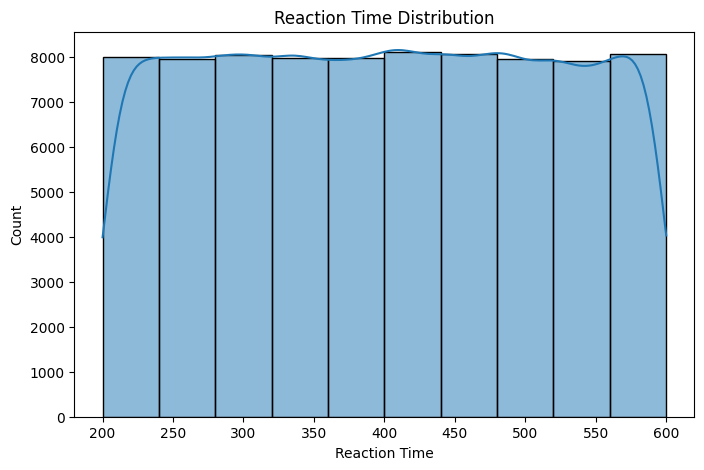

In [14]:
#Plot reaction time vs count as a histogram
plt.figure(figsize=(8, 5))
sns.histplot(df["Reaction_Time"], bins=10, kde=True)
plt.title("Reaction Time Distribution")
plt.xlabel("Reaction Time")
plt.ylabel("Count")
plt.show()

Step 6: Separate Features and Target Variable

In [15]:
# Separate Features and Target Variable (Reaction Time)
y = clean_df["Reaction_Time"]
x = clean_df.drop(columns=["Reaction_Time"])

x.head()

,Age,Gender,Sleep_Duration,Stress_Level,Daily_Screen_Time,Exercise_Frequency,Caffeine_Intake,Memory_Test_Score,Fatigue,Stimulation,Age_Stress,Balance
0,57,1,6.5,3,6.5,1,41,65,3.000000,47.5,171,-2.0
1,39,1,7.6,9,10.8,2,214,58,12.789474,224.8,351,-10.2
2,26,0,8.2,6,5.7,0,429,49,4.170732,434.7,156,-3.5
3,32,0,7.8,9,8.3,0,464,94,9.576923,472.3,288,-9.5
4,50,0,9.7,2,11.3,1,365,62,2.329897,376.3,100,-2.6


df.drop(columns=[...]): Drops the target column from features.

Step 7: Feature Scaling: Normalization and Standardization

In [16]:
# Convert categorical variables into numerical format for the model
# drop_first=True avoids multicollinearity (dummy variable trap)
x = pd.get_dummies(x, columns=["Gender"], drop_first=True)
x = pd.get_dummies(x, columns=["Exercise_Frequency"], drop_first=True)

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
# Fit the scaler to the features and transform them
x_scaled = scaler.fit_transform(x)

In [17]:
# Check parameters of the standard scaler
# This shows the mean and standard deviation used for standardization

print("Means:", scaler.mean_)
print("Standard deviations:", scaler.scale_)

Means: [ 3.85255250e+01  7.00533250e+00  5.49376250e+00  6.50464625e+00
  2.48988213e+02  6.94983500e+01  5.44082465e+00  2.55492859e+02
  2.11646125e+02 -4.19035125e+00  4.80050000e-01  4.09250000e-02
  3.99875000e-01  2.01425000e-01]
Standard deviations: [ 12.10180042   1.7344242    2.86528988   3.16705191 144.54108671
  17.30555105   4.48854799 144.56534736 133.41783669   4.65485483
   0.49960184   0.19811649   0.48987242   0.40106479]


In [18]:
minmax_scaler = MinMaxScaler()
x_normalized = minmax_scaler.fit_transform(x)

# Verify that the scaling worked (Min should be 0, Max should be 1)
print("Min:", x_normalized.min(axis=0))
print("Max:", x_normalized.max(axis=0))


Min: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Max: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


Normalization: Scales all features to a common range so that no variable dominates the analysis.  

Standardization: Centers data around zero mean with unit variance to ensure equal feature contribution.  

Step 8: Correlation Analysis  
Understand relationships between features and the target variable (Outcome)

In [19]:
# Calculate correlations with 'Reaction_Time' and sort them to see strongest predictors
# Positive values indicate positive correlation; negative values indicate inverse correlation
clean_df.corr()["Reaction_Time"].sort_values(ascending=False)

,Reaction_Time
Reaction_Time,1.000000
Stimulation,0.005547
Caffeine_Intake,0.005546
Age,0.004668
Balance,0.003729
Exercise_Frequency,0.002518
Gender,0.000391
Daily_Screen_Time,0.000094
Memory_Test_Score,-0.002262
Fatigue,-0.004625


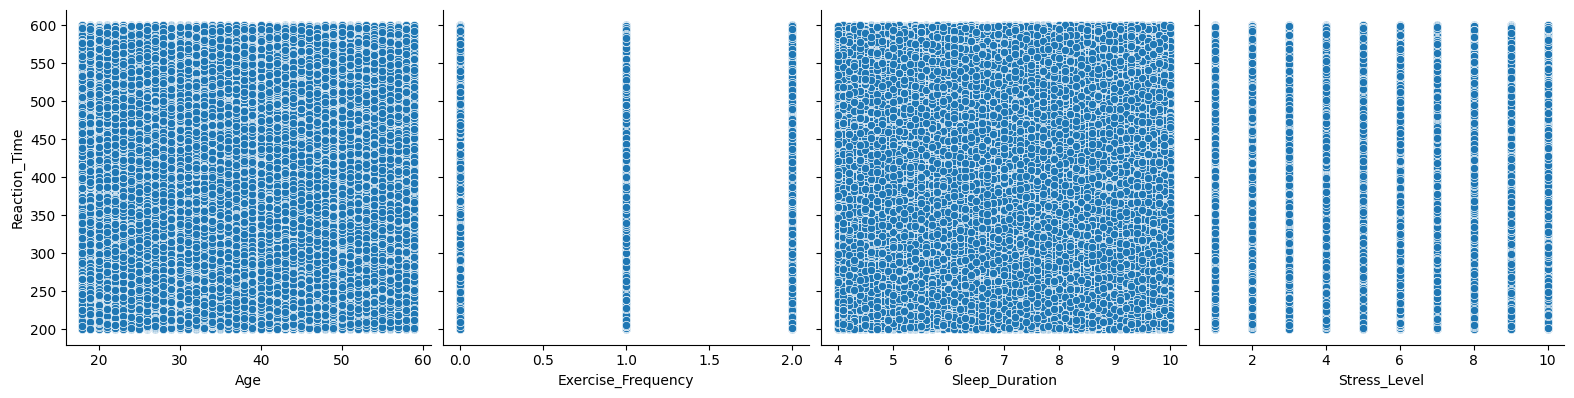

In [20]:
# Create a pairplot to visualize relationships between specific features and Reaction Time to show trends
sns.pairplot(clean_df, x_vars=["Age", "Exercise_Frequency", "Sleep_Duration", "Stress_Level"],
             y_vars=["Reaction_Time"], height=4, kind="scatter")
plt.show()

df.corr(): Computes pairwise correlation coefficients between columns.

Heatmap also helps.

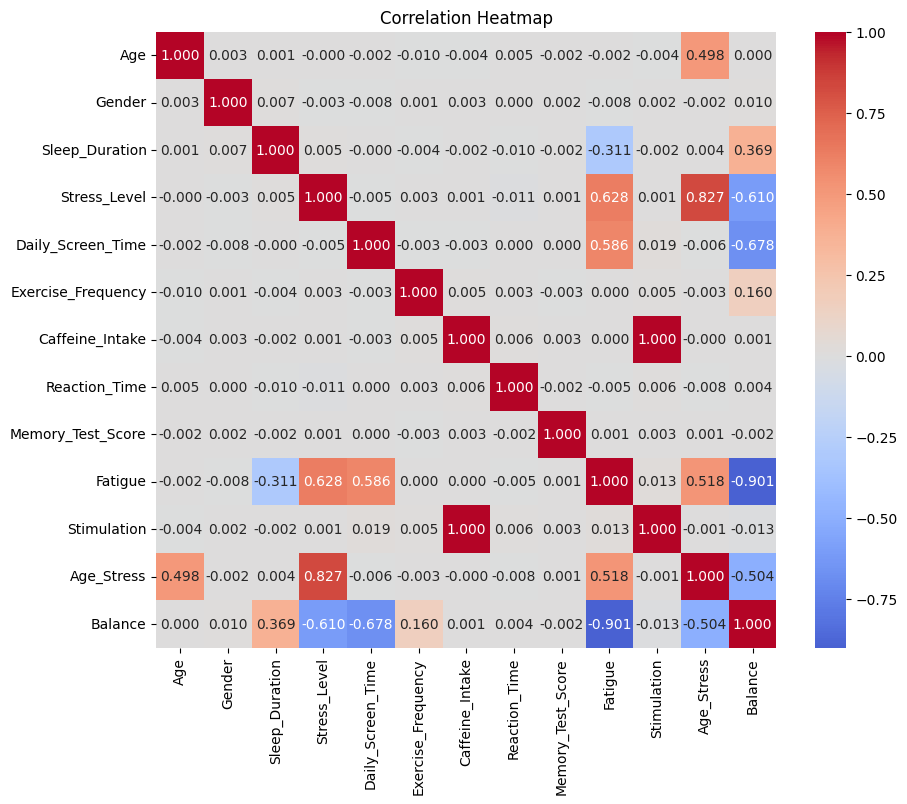

In [21]:
# Calculate the full correlation matrix for all numerical variables
corr_matrix = clean_df.corr()


plt.figure(figsize=(10, 8))
# 'annot=True' shows the numbers, 'cmap="coolwarm"' makes it easy to read (red=high, blue=low)
sns.heatmap(corr_matrix, annot=True, fmt=".3f", cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()

In [22]:
# Save the cleaned dataframe to a new CSV file without the index numbers
clean_df.to_csv("clean_human_cognitive_performance.csv", index=False)

In [23]:
clean_df.describe()

,Age,Gender,Sleep_Duration,Stress_Level,Daily_Screen_Time,Exercise_Frequency,Caffeine_Intake,Reaction_Time,Memory_Test_Score,Fatigue,Stimulation,Age_Stress,Balance
count,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000
mean,38.525525,0.561900,7.005332,5.493762,6.504646,0.802725,248.988213,399.973579,69.498350,5.440825,255.492859,211.646125,-4.190351
std,12.101876,0.572732,1.734435,2.865308,3.167072,0.749143,144.541990,115.369329,17.305659,4.488576,144.566251,133.418671,4.654884
min,18.000000,0.000000,4.000000,1.000000,1.000000,0.000000,0.000000,200.000000,40.000000,0.102041,1.300000,18.000000,-17.700000
25%,28.000000,0.000000,5.500000,3.000000,3.800000,0.000000,123.000000,300.150000,55.000000,1.960000,130.175000,104.000000,-7.500000
50%,39.000000,1.000000,7.000000,5.000000,6.500000,1.000000,249.000000,400.360000,70.000000,4.183673,255.300000,189.000000,-4.200000
75%,49.000000,1.000000,8.500000,8.000000,9.200000,1.000000,375.000000,499.250000,85.000000,7.756098,381.300000,300.000000,-0.900000
max,59.000000,2.000000,10.000000,10.000000,12.000000,2.000000,499.000000,599.990000,99.000000,30.000000,511.000000,590.000000,9.400000


In [24]:
from sklearn.model_selection import train_test_split

# Split data into Features (X) and Target (Y)
# X is all columns except 'Reaction_Time', Y is 'Reaction_Time'

X_train, X_test, Y_train, Y_test = train_test_split(clean_df.drop(columns=["Reaction_Time"]), clean_df["Reaction_Time"])

In [25]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

model = LinearRegression()
# Perform 5-fold Cross-Validation to evaluate model stability
# 'cv=5' splits data into 5 parts and tests the model 5 times

scores = cross_val_score(model, clean_df.drop(columns=["Reaction_Time"]), clean_df["Reaction_Time"], cv=5, scoring='r2')
print(scores)
print("Mean:", scores.mean())

[ 1.43892511e-05 -9.70418773e-04 -2.71496803e-04  3.67915463e-04
 -7.53626825e-05]
Mean: -0.00018699470892993286


Coefficent: [ 0.13685172 -0.12406553 -0.5468029  -0.15845816 -0.12775085 -0.0387679
  0.06722907 -0.02510139 -0.18478744 -0.06052179 -0.00993541 -0.29936179]
Intercept: 402.95507060835774

RMSE: 115.17276573759287 



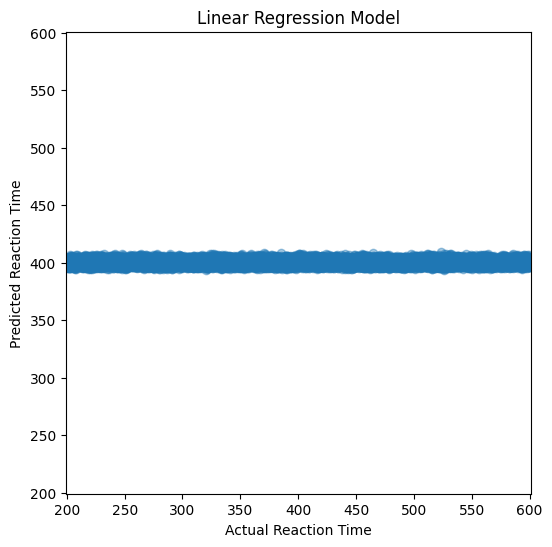

In [26]:
from sklearn.linear_model import LinearRegression

# Initialize and train the Linear Regression model using the training set
model = LinearRegression()
model.fit(X_train, Y_train)

# Print the model coefficients (weights) and intercept (bias)
print("Coefficent:", model.coef_)
print("Intercept:", model.intercept_)

# Predict the Target (Reaction_Time) for the test set
Y_pred = model.predict(X_test)

# Calculate and print Root Mean Squared Error (RMSE) to measure prediction error
mse = mean_squared_error(Y_test, Y_pred)
print("\nRMSE:", np.sqrt(mse),"\n")


# Plot Actual vs Predicted values to visually assess accuracy
plt.figure(figsize=(6, 6))
plt.scatter(Y_test, model.predict(X_test), alpha=0.4)
plt.xlabel("Actual Reaction Time")
plt.ylabel("Predicted Reaction Time")
plt.title("Linear Regression Model")
plt.xlim(Y_test.min()-1, Y_test.max()+1)
plt.ylim(Y_test.min()-1, Y_test.max()+1)
plt.show()


RMSE: 115.37094755998272 



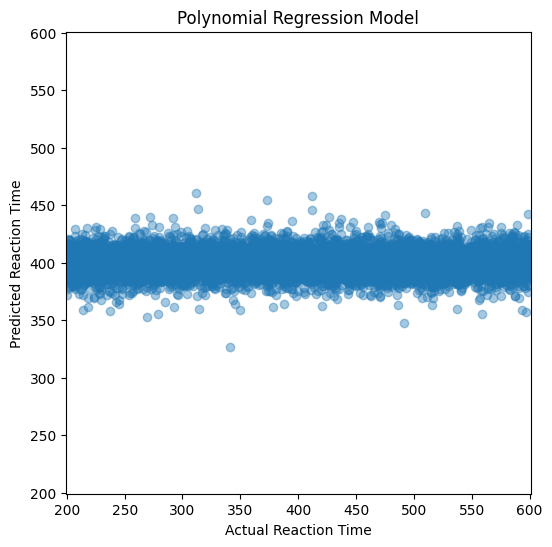

In [27]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso, Ridge
from sklearn.pipeline import make_pipeline


# Create a pipeline that first creates polynomial features (degree 3)
# and then fits a Linear Regression model to those features
model = make_pipeline(PolynomialFeatures(degree=3), LinearRegression())
model.fit(X_train, Y_train)

# Predict using the polynomial model and print MSE
Y_pred = model.predict(X_test)

mse = mean_squared_error(Y_test, Y_pred)
print("\nRMSE:", np.sqrt(mse),"\n")

plt.figure(figsize=(6, 6))
plt.scatter(Y_test, model.predict(X_test), alpha=0.4)
plt.xlabel("Actual Reaction Time")
plt.ylabel("Predicted Reaction Time")
plt.title("Polynomial Regression Model")
plt.xlim(Y_test.min()-1, Y_test.max()+1)
plt.ylim(Y_test.min()-1, Y_test.max()+1)
plt.show()


RMSE: 115.37094755998272 



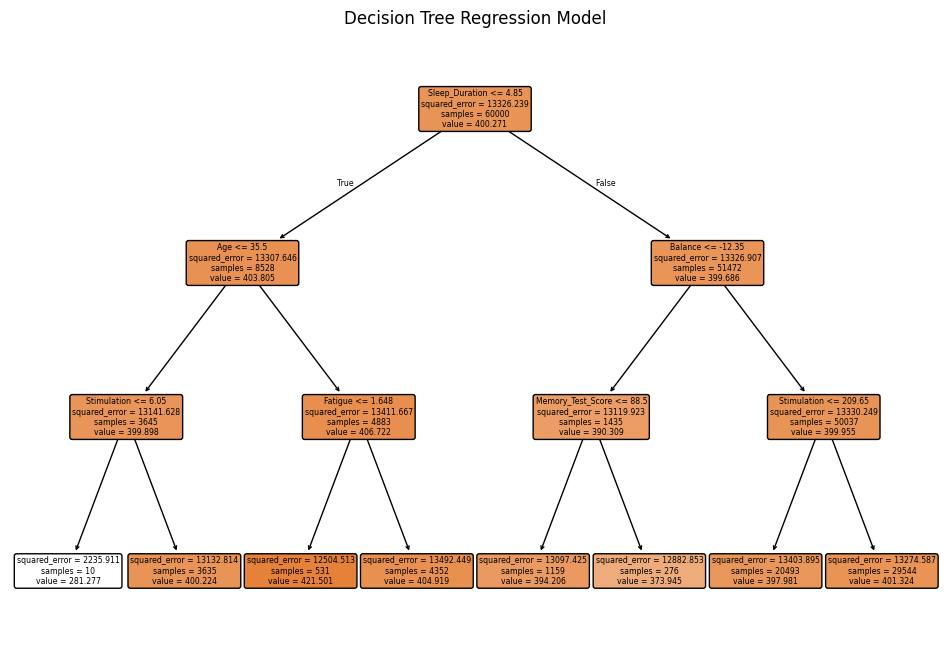

In [28]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

# Initialize Decision Tree Regressor with a max depth of 3 to generate a good visual
regressor = DecisionTreeRegressor(max_depth = 3, random_state=42)
regressor.fit(X_train, Y_train)

# Predict on test set and print RMSE
y_pred = regressor.predict(X_test)

mse = mean_squared_error(Y_test, Y_pred)
print("\nRMSE:", np.sqrt(mse),"\n")

plt.figure(figsize=(12,8))
plot_tree(regressor, max_depth=4, feature_names=X_train.columns,
          filled=True, rounded=True)
plt.title("Decision Tree Regression Model")
plt.show()
